# Let's get the Wikipedia Geodata

In [1]:
from pathlib import Path
import pandas
from wiki_dump_extractor import WikiSqlExtractor, download_file
from tqdm.auto import tqdm

## Download and parse the geodata

This dataset contains sites from wikipedia with latitude, longitude, and category.
It is not well curated, there are many sites without names, many sites without category, many pages which are just lists of things, some sites are actually on the moon, etc. We'll do what we can.

In [2]:
wiki_dir = "https://dumps.wikimedia.org/enwiki/20250220/"
filename = "enwiki-20250220-geo_tags.sql.gz"

download_file(f"{wiki_dir}/{filename}", filename, replace=False)

target = Path("geodata.csv.gz")
if not target.exists():
    columns = ["gt_id", "gt_page_id", "gt_name", "gt_type", "gt_lat", "gt_lon"]
    table = WikiSqlExtractor(filename)
    geo_data_df = table.to_pandas_dataframe(columns=columns)
    geo_data_df.to_csv(target, index=False, compression="gzip")
geo_data_df = pandas.read_csv(target)

enwiki-20250220-geo_tags.sql.gz already exists, skipping download.


## Download and parse the pages data

We'll use this data dump to extract page titles and lengths for each site in the geodata set.

In [3]:
filepath = "enwiki-20250220-page.sql.gz"
download_file(f"{wiki_dir}/{filename}", filename, replace=False)

geodata_page_ids = set(geo_data_df["gt_page_id"])

target = Path("pages.csv.gz")
if not target.exists():
    table = WikiSqlExtractor(filepath)
    pages_df = table.to_pandas_dataframe(
        columns=["page_id", "page_title", "page_len"],
        row_filter=lambda row: row["page_id"] in geodata_page_ids,
    )
    pages_df.to_csv(target, index=False, compression="gzip")
pages_df = pandas.read_csv(target)

enwiki-20250220-geo_tags.sql.gz already exists, skipping download.


## Filter geodata, add geohashes

We filter all the geodata with latitude and longitude that not in the usual earthly range, because these are mostly on other planets (that was weird to me, I thought every planet had the same -180/180, -90/90 coordinates but maybe not)

In [4]:
full_df = geo_data_df.merge(pages_df, left_on="gt_page_id", right_on="page_id")
full_df.rename(
    columns={
        "gt_name": "name",
        "gt_lat": "lat",
        "gt_lon": "lon",
        "gt_type": "category",
    },
    inplace=True,
)
off_limit_coordinates = (full_df["lat"].abs() > 90) | (full_df["lon"].abs() > 180)
full_df[off_limit_coordinates][["page_title"]]

,page_title
6188,The_Anome/Offplanet_places_containing_plaintex...
6189,The_Anome/Offplanet_places_containing_plaintex...
6190,The_Anome/Offplanet_places_containing_plaintex...
6192,The_Anome/Offplanet_places_containing_plaintex...
6193,The_Anome/Offplanet_places_containing_plaintex...
...,...
2590123,List_of_craters_on_Mercury
2605273,List_of_mountains_on_Io
2605274,List_of_mountains_on_Io
2605275,List_of_mountains_on_Io


In [ ]:
import plyvel

with plyvel.DB("../wiki_dump_idx") as db:
    page_titles = set(
        page_title.decode().replace(" ", "_") for page_title, _ in db.iterator()
    )
is_in_wiki_dump = full_df.page_title.isin(page_titles)

In [5]:
from_list = full_df.page_title.str.contains("List_of")
from_user = full_df.page_title.str.contains("/")
is_crater = full_df.page_title.str.lower().str.contains("crater")
is_pic = full_df.page_title.str.lower().str.contains("jpg")
df = full_df[
    is_in_wiki_dump
    & (~off_limit_coordinates)
    & (~from_list)
    & (~from_user)
    & (~is_crater)
    & (~is_pic)
].copy()
print("Length before filtering", len(full_df))
print("Length after filtering", len(df))

Length before filtering 2615036
Length after filtering 1913662


<GeoAxes: >

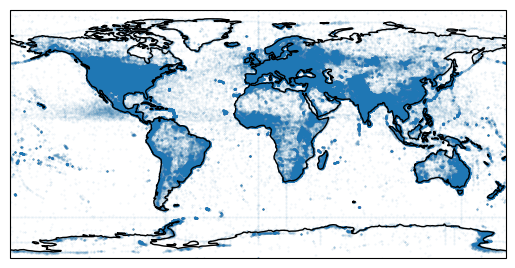

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def plot_df(df, **scatter_kwargs):
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.scatter(df["lon"], df["lat"], transform=ccrs.PlateCarree(), **scatter_kwargs)
    return ax


plot_df(df, s=0.1, alpha=0.1)

### Compute the geohashes for each site

We will use this modified geohash (it uses mostly base-4, which is perfect because the leaflet zoom basically zooms by factors of 2/4).

We will also use the geohashes to deduplicate entries - but not before we've sorted the pages in the most interesting order possible.

In [7]:
from hybrid_geoencoding import encode_hybrid

df["geohash4"] = [
    encode_hybrid(lat, lng, base4_precision=16)
    for lat, lng in zip(df["lat"], df["lon"])
]


### Keep cities over events that happened in the cities

We want to know which entries are cities so we make sure to keep them.

Keeping cities is important because users will search for e.g. "Paris" in search bar.
We need to make sure that Paris is in the database, and hasn't been replaced by "2024 Olympics", just because the latter has the same location has a larger wikipedia page.

In [8]:
filepath = "enwiki-20250220-page.sql.gz"
download_file(
    "https://download.geonames.org/export/dump/cities5000.zip",
    "cities5000.zip",
    replace=False,
)
columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature class",
    "feature code",
    "country code",
    "cc2",
    "admin1 code",
    "admin2 code",
    "admin3 code",
    "admin4 code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modification date",
]
cities_df = pandas.read_csv("cities5000.zip", sep="\t", header=None, names=columns)
cities_df
city_names = set(cities_df.asciiname.str.lower())
df["is_city"] = df.page_title.str.lower().isin(city_names)
sum(df.is_city)

cities5000.zip already exists, skipping download.


27359

### Define a score for each location

It is defined as page_length / number_of_locations_in_page.

It will be used so that locations with larger wikipedia page appear preferentially.

In [9]:
page_occurences = df.groupby("page_title")["page_title"].count().to_dict()
df["score"] = [
    page_len / page_occurences[page_title]
    for page_title, page_len in zip(df["page_title"], df["page_len"])
]
df = df.sort_values(["is_city", "score"], ascending=False)
df = df.drop_duplicates(subset=["geohash4"])
df = df.sort_values("score", ascending=True)
"Paris" in set(df.page_title)

True

### Attribute a "zoom level" to each location

This is used to reveal the locations as the user zooms in


In [ ]:
best_scoring = {}
counts = {}
for geohash in tqdm(df["geohash4"]):
    for subgeohash in [geohash[:i] for i in range(1, 17)]:
        best_scoring[subgeohash] = geohash
        counts[subgeohash] = counts.get(subgeohash, 0) + 1
level_by_geohash = {}
for subgeohash, geohash in tqdm(best_scoring.items()):
    level_by_geohash[geohash] = min(level_by_geohash.get(geohash, 17), len(subgeohash))


We sort the sites by decreasing score now. This is the order they will be in the database. It's a nice way to always now that the elements returned are sorted by relevance.

<GeoAxes: >

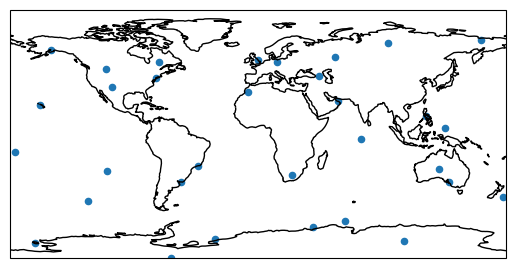

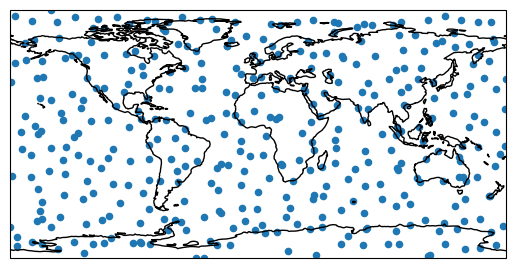

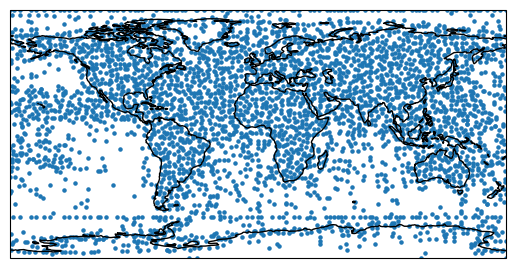

In [11]:
df["zoom_level"] = df["geohash4"].map(level_by_geohash).fillna(17).astype(int)
df["geokey"] = [
    geohash[:zoom_level]
    for geohash, zoom_level in zip(df["geohash4"], df["zoom_level"])
]
df["geokey_complement"] = [
    geohash[zoom_level:]
    for geohash, zoom_level in zip(df["geohash4"], df["zoom_level"])
]

plot_df(df.query("zoom_level == 1"), s=20, alpha=1)
plot_df(df.query("zoom_level == 3"), s=20, alpha=1)
plot_df(df.query("zoom_level == 5"), s=5, alpha=1)


## Write the data to disk

Unfortunately the only way we'll be able to send that data to cloudflare is if we write in into small SQL files (it has to be `.sql` files).

So here we first build the SQL commands, then we'll write them to disk (for Cloudflare upload) at the same time that we use them to populate our local sqlite database (which we'll use for local development)

In [20]:
columns = [
    "geokey",
    "geokey_complement",
    "category",
    "name",
    "page_title",
]
batch_size = 10000  # Adjust based on your dataset size and memory constraints

create_table = """
CREATE TABLE IF NOT EXISTS geodata (
    geokey TEXT PRIMARY KEY,
    geokey_complement TEXT NOT NULL,
    category TEXT,
    name TEXT,
    page_title TEXT
)
"""

create_index = """
CREATE VIRTUAL TABLE text_search USING fts5(
    name,
    page_title,
    content='geodata',
    content_rowid='rowid'
);
"""

fill_index = """
INSERT INTO text_search(rowid, name, page_title)
SELECT rowid, name, page_title FROM geodata;
"""


def format_value(v):
    if str(v) in ["None", "nan"]:
        return "null"
    if isinstance(v, str):
        escaped = v.replace("'", "''")
        return f"'{escaped}'"
    # float etc.
    return str(v)


def row_to_sql_value_tuple(row):
    return "(" + ",".join([format_value(v) for v in row]) + ")"


def df_to_insert_statement(df, table, columns):
    # Construct a single INSERT statement with multiple value tuples
    # Group value tuples into batches that don't exceed 90,000 characters
    value_tuples = []
    current_batch = []
    current_batch_size = 0

    for row in df[columns].values.tolist():
        tuple_str = row_to_sql_value_tuple(row)
        tuple_size = len(tuple_str) + 2  # +2 for the comma and space

        # If adding this tuple would exceed the limit, start a new batch
        if current_batch_size + tuple_size > 90000 and current_batch:
            value_tuples.append(", ".join(current_batch))
            current_batch = [tuple_str]
            current_batch_size = tuple_size
        else:
            current_batch.append(tuple_str)
            current_batch_size += tuple_size

    # Add the last batch if it's not empty
    if current_batch:
        value_tuples.append(", ".join(current_batch))

    # Create multiple INSERT statements if needed
    if len(value_tuples) == 1:
        return f"INSERT INTO {table} ({', '.join(columns)}) VALUES {value_tuples[0]};"
    else:
        return "\n\n".join(
            [
                f"INSERT INTO {table} ({', '.join(columns)}) VALUES {batch};"
                for batch in value_tuples
            ]
        )


batch_size = 6000
df = df.sort_values("score", ascending=False)
insert_batches = [
    df_to_insert_statement(df[i : i + batch_size], "geodata", columns)
    for i in tqdm(range(0, len(df), batch_size))
]


  0%|          | 0/257 [00:00<?, ?it/s]

In [22]:
!cp geodata_db.sqlite ../../landnotes-cloudflare/.wrangler/state/v3/d1/miniflare-D1DatabaseObject/e66eef3cbd4565d3e69f1f2434191bfdb37ef22f3df39fee3383b9b23eb1612d.sqlite
!rm -rf ../../landnotes-cloudflare/local_assets/sql_dump
!cp -r sql_dump/ ../../landnotes-cloudflare/local_assets/sql_dump

### Build the hotspot prefix tree

We want to give the user a visual cue of the most wikipedied locations (the orange "hoptspot zones").

We use counts gathered for each partial geohash to build a prefix tree of the hottest locations.
    
This gives us a world-wide heatmap with 16 levels of zoom for only ~150kb zipped.

In [21]:
import sqlite3
import os
import shutil

all_statements = [create_table, *insert_batches, create_index, fill_index]

geodata_db = "geodata_db.sqlite"
if os.path.exists(geodata_db):
    os.remove(geodata_db)

sql_dir = "sql_dump"
if os.path.exists(sql_dir):
    shutil.rmtree(sql_dir)
os.makedirs(sql_dir, exist_ok=True)

conn = sqlite3.connect(geodata_db)
# Enable foreign keys and set pragmas for better performance
cursor = conn.cursor()
for i, statement in enumerate(tqdm(all_statements)):
    with open(f"{sql_dir}/f{i:05d}.sql", "w") as f:
        f.write(statement)
    for sub_statement in statement.split("\n\n"):
        cursor.execute(sub_statement)
conn.commit()
conn.close()

  0%|          | 0/260 [00:00<?, ?it/s]

In [71]:
filtered_counts = {k: v for k, v in counts.items() if v > 5}
len(filtered_counts)
keys_by_parent = {}
for key in filtered_counts.keys():
    parent = key[:-4]
    if parent == "":
        continue
    if parent not in keys_by_parent:
        keys_by_parent[parent] = []
    keys_by_parent[parent].append(key)

keys_by_parent = {k: v for k, v in keys_by_parent.items() if len(v) > 1}
keys_by_parent_filtered = {
    key: sorted(children, key=counts.get, reverse=True)[:25]
    for key, children in keys_by_parent.items()
}

geohashes = [vv for v in keys_by_parent_filtered.values() for vv in v]

# ==== Build the prefix tree ====


def build_prefix_tree(strings):
    trie = {}
    for s in strings:
        current = trie
        for char in s:
            if char not in current:
                current[char] = {}
            current = current[char]
        current["$"] = True  # Mark end of string
    return trie


# Build the prefix tree
prefix_tree = build_prefix_tree(geohashes)

# Print the first level of the tree to see the structure
print(f"Total unique geohashes: {len(geohashes)}")


Total unique geohashes: 127801


In [29]:
# === SAVE to ZIP
import json
import zipfile
import io


def save_prefix_tree(prefix_tree, filename):
    # Convert the prefix tree to JSON
    prefix_tree_json = json.dumps(prefix_tree)

    # Write the JSON to a zip file
    with zipfile.ZipFile(filename, "w", compression=zipfile.ZIP_DEFLATED) as zipf:
        # Create a file-like object from the JSON string
        data = io.BytesIO(prefix_tree_json.encode("utf-8"))
        # Add the JSON data to the zip file
        zipf.writestr("prefix_tree.json", data.getvalue())
